In [3]:
pip install -U imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!/usr/bin/env python3
"""
improved_lbp_glcm_pipeline.py

- ROI extraction (consistent normal/abnormal)
- per-ROI CLAHE
- LBP pooled features (adaptive bins)
- quantized GLCM features
- SelectKBest feature selection inside pipeline
- SMOTE inside CV if available, else class_weight fallback
- nested GroupKFold (inner) GridSearchCV and held-out GroupShuffleSplit
- prints and saves results to ./results/
"""
import os
import math
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import Counter
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

# try to import imblearn (SMOTE & pipeline). If missing fallback will be used.
USE_SMOTE = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    USE_SMOTE = False
    ImbPipeline = None
    print("[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.")

# ----------------- USER CONFIG -----------------
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024               # MIAS image size reference
TARGET_SIZE = 128               # None to keep native crop size, or int to resize (128 recommended)
MIN_SIDE = 32                   # pad if ROI smaller
CLAHE_CLIP = 2.0
CLAHE_TILE = (8, 8)

# LBP params
P = 8
# You can enable multi-scale LBP; set RB list to include desired radii:
LBP_RADII = [1, 3]             # set to [3] or [1,3] for multiscale
LBP_METHOD = 'uniform'

# pooling grid for LBP
POOL_G = 3                      # 3x3 pooling (try 3,4,6). smaller reduces dims

# GLCM params (quantized)
GLCM_LEVELS = 32
GLCM_DISTANCES = [1, 3]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# CV params
OUTER_SPLITS = 5
INNER_SPLITS = 4
RANDOM_STATE = 42
HOLDOUT_TEST_SIZE = 0.2

# Grid search params
RF_PARAM_GRID = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_leaf': [2, 6],
}
SVM_PARAM_GRID = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 0.01],
}

SELECT_K = 80  # number of features to keep with SelectKBest (set based on experiments)

# ------------------------------------------------

# ---------- helper functions ----------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    return df

def ref_to_patient_id(ref):
    try:
        n = int(''.join(ch for ch in ref if ch.isdigit()))
        return (n - 1) // 2
    except:
        return ref

def clamp(a, lo, hi):
    return max(lo, min(hi, a))

def crop_square(img, cx, cy, r):
    H, W = img.shape
    x0 = clamp(cx - r, 0, W)
    x1 = clamp(cx + r, 0, W)
    y0 = clamp(cy - r, 0, H)
    y1 = clamp(cy + r, 0, H)
    if x1 <= x0 or y1 <= y0:
        return img.copy()
    return img[y0:y1, x0:x1]

def pad_to_min_side(img, min_side):
    h, w = img.shape
    top = bottom = left = right = 0
    if h < min_side:
        extra = min_side - h
        top = extra // 2
        bottom = extra - top
    if w < min_side:
        extra = min_side - w
        left = extra // 2
        right = extra - left
    if any([top, bottom, left, right]):
        img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_REFLECT)
    return img

def apply_clahe_to_roi(roi, clip=2.0, tile=(8,8)):
    if roi.dtype != np.uint8:
        if roi.max() <= 1.0:
            roi_u8 = (roi * 255).astype(np.uint8)
        else:
            roi_u8 = roi.astype(np.uint8)
    else:
        roi_u8 = roi
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(roi_u8)

def pooled_lbp_matrix(lbp_map, G=3, n_bins=None):
    H, W = lbp_map.shape
    row_edges = np.linspace(0, H, G+1, dtype=int)
    col_edges = np.linspace(0, W, G+1, dtype=int)
    rows = []
    # use dynamic n_bins from caller
    for i in range(G):
        for j in range(G):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]
            region = lbp_map[r0:r1, c0:c1]
            # ensure integer codes
            region_int = region.ravel().astype(int)
            if n_bins is None:
                n_bins_reg = int(region_int.max()) + 1 if region_int.size>0 else 1
                hist = np.bincount(region_int, minlength=n_bins_reg).astype(float)
            else:
                hist = np.bincount(region_int, minlength=n_bins).astype(float)
            if hist.sum() > 0:
                hist /= hist.sum()
            # if n_bins is provided, hist length is fixed
            if n_bins is not None and len(hist) < n_bins:
                # pad
                hist = np.pad(hist, (0, n_bins - len(hist)), mode='constant')
            rows.append(hist)
    M = np.vstack(rows)
    return M

def quantize_img_levels(img, levels=32):
    a = img.astype(np.float32)
    if a.max() > 1.1:
        a = a / 255.0
    q = np.floor(a * (levels - 1) + 0.5).astype(np.uint8)
    return q

def extract_glcm_features(patch, distances, angles, levels):
    q = quantize_img_levels(patch, levels=levels)
    glcm = graycomatrix(q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = []
    for p in props:
        mat = graycoprops(glcm, p)
        feats.append(float(np.nanmean(mat)))
        feats.append(float(np.nanvar(mat)))
    return np.array(feats, dtype=float)  # length = 2 * len(props)

# ---------- main ----------
def main():
    print("[INFO] Reading metadata...")
    df = read_metadata(META_PATH)
    refs = sorted([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(refs)} image files in {IMAGES_DIR}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # ROI extraction
    rois = []
    rois_raw = []   # keep a raw copy (pre-CLAHE) for comparisons
    labels = []
    groups = []
    ref_list = []

    for fname in refs:
        ref = os.path.splitext(fname)[0]
        row = df[df['REFNUM'] == ref]
        if row.empty:
            continue
        row = row.iloc[0]
        img_path = os.path.join(IMAGES_DIR, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("[WARN] cannot read", img_path); continue

        label = int(row['CANCER'])
        x, y, r = row['X'], row['Y'], row['RADIUS']

        if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
            cx = int(float(x))
            cy = int(IMAGE_SIZE - float(y))  # convert bottom-left MIAS to top-left indexing
            rr = int(max(int(r), 8))
            roi = crop_square(img, cx, cy, rr)
        else:
            cx = img.shape[1] // 2
            cy = img.shape[0] // 2
            rr = median_radius
            roi = crop_square(img, cx, cy, rr)

        roi = pad_to_min_side(roi, MIN_SIDE)
        rois_raw.append(roi.copy())
        roi_clahe = apply_clahe_to_roi(roi, clip=CLAHE_CLIP, tile=CLAHE_TILE)
        if TARGET_SIZE is not None:
            if roi_clahe.shape[0] > TARGET_SIZE or roi_clahe.shape[1] > TARGET_SIZE:
                interp = cv2.INTER_AREA
            else:
                interp = cv2.INTER_LINEAR
            roi_clahe = cv2.resize(roi_clahe, (TARGET_SIZE, TARGET_SIZE), interpolation=interp)

        rois.append(roi_clahe)
        labels.append(label)
        groups.append(ref_to_patient_id(ref))
        ref_list.append(ref)

    print(f"[INFO] Extracted {len(rois)} ROIs (CLAHE applied per-ROI).")
    if len(rois) == 0:
        raise RuntimeError("No ROIs extracted - check dataset paths and metadata.")

    # Compute LBP maps for each radius and collect global max code to set fixed bins
    print("[INFO] Computing LBP maps for radii:", LBP_RADII)
    lbp_maps_per_radius = {r: [] for r in LBP_RADII}
    max_code = 0
    for roi in rois:
        # ensure float input
        img_float = roi.astype(np.float32)
        for r in LBP_RADII:
            lbp_map = local_binary_pattern(img_float, P, r, method=LBP_METHOD)
            # LBP returns floats; convert to ints safely
            lbp_int = np.round(lbp_map).astype(int)
            lbp_maps_per_radius[r].append(lbp_int)
            max_code = max(max_code, int(lbp_int.max()))

    n_lbp_bins = max_code + 1
    print(f"[INFO] Determined LBP n_bins = {n_lbp_bins}")

    # Build feature matrices
    X_lbp_parts = []  # will contain per-radius pooled LBP flattened
    X_glcm = []
    print("[INFO] Building pooled LBP histograms and GLCM features for each ROI...")
    for idx, roi in enumerate(rois):
        roi_uint8 = roi.astype(np.uint8)
        # LBP pooled for each radius, concatenate
        lbp_concat = []
        for r in LBP_RADII:
            lbp_map = lbp_maps_per_radius[r][idx]
            M = pooled_lbp_matrix(lbp_map, G=POOL_G, n_bins=n_lbp_bins)  # shape (G*G, n_bins)
            lbp_concat.append(M.ravel())
        lbp_vec = np.hstack(lbp_concat)
        X_lbp_parts.append(lbp_vec)

        # GLCM features (quantized)
        glcm_feats = extract_glcm_features(roi_uint8, distances=GLCM_DISTANCES, angles=GLCM_ANGLES, levels=GLCM_LEVELS)
        X_glcm.append(glcm_feats)

    X_lbp = np.vstack(X_lbp_parts)
    X_glcm = np.vstack(X_glcm)
    X = np.hstack([X_glcm, X_lbp])
    y = np.array(labels)
    groups_arr = np.array(groups)

    print("[INFO] Feature shapes: X_glcm", X_glcm.shape, "X_lbp", X_lbp.shape, "combined X", X.shape)
    print("Label counts:", Counter(y))
    # safety check
    if np.isnan(X).any():
        raise RuntimeError("NaN found in features!")

    # Create feature names for mapping importances
    glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    glcm_names = []
    for p in glcm_props:
        glcm_names += [f"{p}_mean", f"{p}_var"]
    lbp_names = []
    region_count = POOL_G * POOL_G
    for r in LBP_RADII:
        for region_ix in range(region_count):
            for code in range(n_lbp_bins):
                lbp_names.append(f"LBP_R{r}_r{region_ix:02d}_c{code:03d}")
    feature_names = glcm_names + lbp_names
    assert X.shape[1] == len(feature_names)

    # ---------------- train/test split (group-aware held-out) ----------------
    gss = GroupShuffleSplit(n_splits=1, test_size=HOLDOUT_TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups_arr))
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    groups_tr, groups_te = groups_arr[train_idx], groups_arr[test_idx]
    print("[INFO] Train samples:", X_tr.shape[0], "Test samples:", X_te.shape[0])

    # Build pipelines: keep feature selection inside pipeline (SelectKBest)
    selector = SelectKBest(mutual_info_classif, k=min(SELECT_K, X_tr.shape[1]))

    # If SMOTE available, put inside ImbPipeline, else use sklearn Pipeline and class_weight
    if USE_SMOTE:
        rf_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])
    else:
        rf_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])

    # inner CV uses GroupKFold on training set
    def run_gridsearch(pipeline, param_grid, X_train, y_train, groups_train, name="model"):
        inner_cv = GroupKFold(n_splits=INNER_SPLITS)
        gs = GridSearchCV(pipeline, param_grid, cv=inner_cv.split(X_train, y_train, groups_train),
                          scoring='roc_auc', n_jobs=-1, verbose=1)
        gs.fit(X_train, y_train)
        print(f"[INFO] Best {name} params:", gs.best_params_)
        return gs.best_estimator_, gs

    print("[INFO] Running inner grid-search for RandomForest...")
    best_rf, rf_gs = run_gridsearch(rf_pipeline, RF_PARAM_GRID, X_tr, y_tr, groups_tr, name="RandomForest")

    print("[INFO] Running inner grid-search for SVM...")
    best_svm, svm_gs = run_gridsearch(svm_pipeline, SVM_PARAM_GRID, X_tr, y_tr, groups_tr, name="SVM")

    # Evaluate on held-out test set
    def evaluate_model(est, X_test, y_test, name="model"):
        y_pred = est.predict(X_test)
        if hasattr(est, "predict_proba"):
            try:
                y_prob = est.predict_proba(X_test)[:, 1]
            except Exception:
                y_prob = None
        else:
            y_prob = None
        print(f"\n=== Held-out evaluation: {name} ===")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred, zero_division=0))
        if y_prob is not None and len(np.unique(y_test)) > 1:
            print("AUC:", roc_auc_score(y_test, y_prob))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        return y_pred, y_prob

    ypred_rf, yprob_rf = evaluate_model(best_rf, X_te, y_te, name="RandomForest (best)")
    ypred_svm, yprob_svm = evaluate_model(best_svm, X_te, y_te, name="SVM (best)")

    # Feature importances mapping (RF)
    try:
        rf_clf = best_rf.named_steps['clf'] if USE_SMOTE else best_rf.named_steps['clf']
        importances = rf_clf.feature_importances_
        # map to names
        idxs = np.argsort(importances)[::-1][:30]
        print("\nTop 30 feature importances (index, name, importance):")
        for idx in idxs:
            print(idx, feature_names[idx], f"{importances[idx]:.4f}")
    except Exception as e:
        print("[WARN] Could not extract feature importances:", e)

    # Threshold tuning on held-out set to prioritize recall if desired (example)
    if yprob_rf is not None:
        best_thresh = 0.5
        best_recall = recall_score(y_te, (yprob_rf >= 0.5).astype(int))
        # choose threshold that maximizes recall while keeping precision >= 0.5 (example)
        for t in np.linspace(0.1, 0.9, 81):
            preds_t = (yprob_rf >= t).astype(int)
            r = recall_score(y_te, preds_t, zero_division=0)
            # for illustration choose threshold maximizing recall
            if r > best_recall:
                best_recall = r; best_thresh = t
        print(f"[INFO] RF held-out best threshold for recall (example): {best_thresh:.2f}, recall={best_recall:.3f}")
        # show confusion at best threshold
        preds_best = (yprob_rf >= best_thresh).astype(int)
        print("Confusion at chosen threshold:\n", confusion_matrix(y_te, preds_best))
        print(classification_report(y_te, preds_best))

    # Save outputs
    os.makedirs("results", exist_ok=True)
    with open(os.path.join("results", "features_X_y_groups.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr, "ref_list": ref_list, "feature_names": feature_names}, f)
    with open(os.path.join("results", "best_rf.pkl"), "wb") as f:
        pickle.dump(best_rf, f)
    with open(os.path.join("results", "best_svm.pkl"), "wb") as f:
        pickle.dump(best_svm, f)

    print("\n[INFO] Done. Results and models saved to ./results/")

if __name__ == "__main__":
    main()


[INFO] Reading metadata...
[INFO] Found 324 image files in all-mias
[INFO] median radius: 43
[INFO] Extracted 324 ROIs (CLAHE applied per-ROI).
[INFO] Computing LBP maps for radii: [1, 3]


C:\Python3\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[INFO] Determined LBP n_bins = 10
[INFO] Building pooled LBP histograms and GLCM features for each ROI...
[INFO] Feature shapes: X_glcm (324, 12) X_lbp (324, 180) combined X (324, 192)
Label counts: Counter({0: 207, 1: 117})
[INFO] Train samples: 258 Test samples: 66
[INFO] Running inner grid-search for RandomForest...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[INFO] Best RandomForest params: {'clf__max_depth': 12, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 300}
[INFO] Running inner grid-search for SVM...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[INFO] Best SVM params: {'clf__C': 1, 'clf__gamma': 0.01}

=== Held-out evaluation: RandomForest (best) ===
Accuracy: 0.8787878787878788
Recall: 0.7916666666666666
AUC: 0.9305555555555556
Confusion Matrix:
 [[39  3]
 [ 5 19]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.86      0.79      0.83        24

    accuracy  

In [2]:
# after computing lbp (2D array) for a sample:
unique_codes = np.unique(lbp).astype(int)
n_bins = int(unique_codes.max()) + 1
print("LBP unique codes:", unique_codes[:10], "... max code:", n_bins-1)

# Then when you compute hist:
hist, _ = np.histogram(region.ravel(), bins=n_bins, range=(0, n_bins))


NameError: name 'lbp' is not defined

In [4]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
import albumentations as A

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

at above we import all the libraries requaredaa

In [5]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Load the data table
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

all_images = []
all_labels = []
all_groups = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            # Apply CLAHE to enhance contrast
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img_eq = clahe.apply(img_array)

            # Resize the entire image to 256x256 (no ROI used)
            resized_img = cv2.resize(img_eq, (256, 256), interpolation=cv2.INTER_AREA)

            label = record['CANCER'].iloc[0]
            all_images.append(resized_img)
            all_labels.append(label)
            all_groups.append(ref_num[:-1])  # remove last char if needed for grouping

print("Data has been loaded successfully.")
print(f"Total images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")



Data has been loaded successfully.
Total images: 324
Total labels: 324


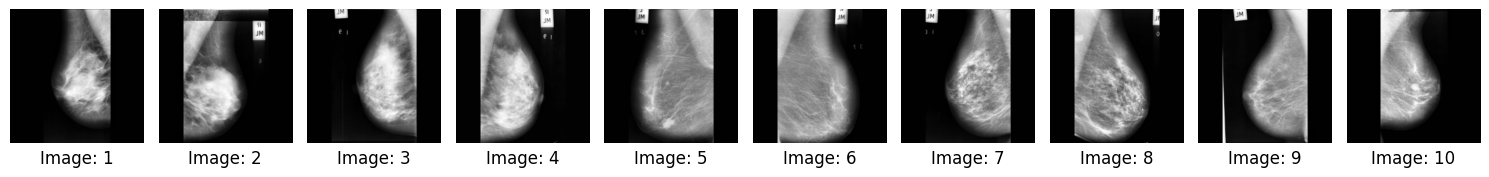

In [7]:
import matplotlib.pyplot as plt

# Display 5 images with labels underneath
plt.figure(figsize=(15, 5))  # wide figure

for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    ax.imshow(all_images[i], cmap='gray')
    # plt.titlx(f"Label: {all_labels[i]}")
    plt.axis('off')
    ax.axis('off')  # remove axis ticks
    
    # Add label text BELOW the image
    label = all_labels[i]
    label_text = f"Image: {i+1}"
    
    # Use plt.text with transform=ax.transAxes to place text relative to the axes
    ax.text(0.5, -0.15, label_text, fontsize=12, ha='center', transform=ax.transAxes)

# plt.suptitle("First 5 Images with Labels Below", fontsize=16)
plt.tight_layout()
plt.show()


ValueError: num must be an integer with 1 <= num <= 2, not 3

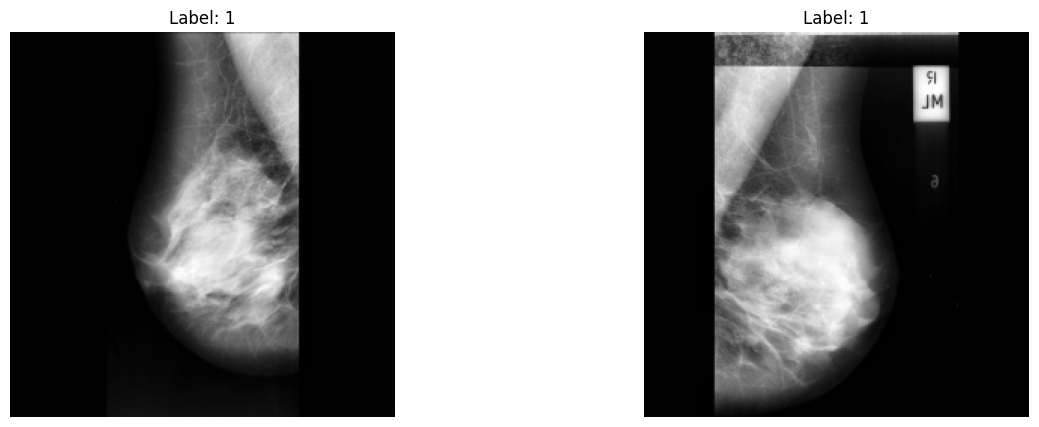

In [8]:
# Show first 5 images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 2, i + 1)
    plt.imshow(all_images[i], cmap='gray')
    plt.title(f"Label: {all_labels[i]}")
    plt.axis('off')
    
    label_text = "Cancer" if label == 1 else "Normal"
    plt.xlabel(label_text, fontsize=12)
    label = all_labels[i]
    plt.xlabel("label", fontsize=12)
    plt.xlabel(f"Label: {label}", fontsize=12)
# plt.suptitle("First 5 Full Images (No ROI)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# # --- Configuration ---
# RAW_IMG_PATH = "all-mias"  # The folder with your mixed-up .pgm images
# MASTER_CSV_PATH = "data2.txt" # Your master data file
# OUTPUT_DATASET_PATH = "dataset_for_training" # Where we will create the sorted folders

# # --- Step 1: Load and Prepare the Master DataFrame ---
# print("Loading and preparing the master DataFrame...")
# col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
# df = pd.read_csv(MASTER_CSV_PATH, sep="\s+", names=col_names, header=None)

# # Create the binary 'CANCER' label (1 for any abnormality, 0 for normal)
# df['CANCER'] = df['CLASS'].apply(lambda x: 0 if x == 'NORM' else 1)
# print(f"DataFrame loaded. Total images: {len(df)}. Cancer cases: {df['CANCER'].sum()}.")


# # --- Step 2: Split the DataFrame into Training and Validation Sets ---
# # We split the DataFrame first to ensure a clean separation of data.
# # stratify=df['CANCER'] ensures both train and validation sets have a similar percentage of cancer cases.
# print("Splitting DataFrame into training and validation sets...")
# train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['CANCER'])
# print(f"Training set size: {len(train_df)}, Validation set size: {len(validation_df)}")


# # --- Step 3: The Core Processing Function ---
# def create_dataset(dataframe, source_img_folder, output_folder):
#     """
#     Reads a dataframe, processes the corresponding images, and saves them
#     into 'cancer' and 'normal' subdirectories.
#     """
#     print(f"Processing images for: {output_folder}")
#     # Create the output directories if they don't exist
#     cancer_path = os.path.join(output_folder, 'cancer')
#     normal_path = os.path.join(output_folder, 'normal')
#     os.makedirs(cancer_path, exist_ok=True)
#     os.makedirs(normal_path, exist_ok=True)

#     for index, row in dataframe.iterrows():
#         refnum = row['REFNUM']
#         is_cancer = row['CANCER']
#         image_filename = f"{refnum}.pgm"
#         image_filepath = os.path.join(source_img_folder, image_filename)

#         if not os.path.exists(image_filepath):
#             print(f"Warning: Image file not found for {refnum}, skipping.")
#             continue

#         # Load the image in grayscale
#         img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
#         if img is None:
#             print(f"Warning: Could not read image {image_filename}, skipping.")
#             continue

#         # If it's an abnormal case, extract the ROI
#         if is_cancer == 1 and pd.notna(row['X']):
#             # Use a mask to extract the circular ROI
#             x, y, r = int(row['X']), int(row['Y']), int(row['RADIUS'])
#             y_adj = 1024 - y # Adjust y-coordinate
#             mask = np.zeros_like(img)
#             cv2.circle(mask, (x, y_adj), r, 255, -1)
            
#             # Get the bounding box of the circle to crop the image
#             x_min, x_max = max(0, x - r), min(img.shape[1], x + r)
#             y_min, y_max = max(0, y_adj - r), min(img.shape[0], y_adj + r)
            
#             # Crop the image and the mask
#             cropped_img = img[y_min:y_max, x_min:x_max]
#             cropped_mask = mask[y_min:y_max, x_min:x_max]
            
#             # Apply mask to the cropped image
#             final_roi = cv2.bitwise_and(cropped_img, cropped_img, mask=cropped_mask)
            
#             # Save the processed ROI
#             output_filepath = os.path.join(cancer_path, f"{refnum}_roi.png")
#             cv2.imwrite(output_filepath, final_roi)

#         # If it's a normal case, extract a central patch
#         elif is_cancer == 0:
#             # Extract a 224x224 central patch as a sample of normal tissue
#             h, w = img.shape
#             crop_size = 224
#             start_h, start_w = h // 2 - crop_size // 2, w // 2 - crop_size // 2
#             normal_patch = img[start_h : start_h + crop_size, start_w : start_w + crop_size]

#             # Save the normal patch
#             output_filepath = os.path.join(normal_path, f"{refnum}_normal_patch.png")
#             cv2.imwrite(output_filepath, normal_patch)

# # --- Step 4: Run the dataset creation for both sets ---
# create_dataset(train_df, RAW_IMG_PATH, os.path.join(OUTPUT_DATASET_PATH, 'train'))
# create_dataset(validation_df, RAW_IMG_PATH, os.path.join(OUTPUT_DATASET_PATH, 'validation'))

# print("\nDataset creation complete!")
# print(f"Your training-ready dataset is located in: {OUTPUT_DATASET_PATH}")

In [9]:
df = pd.read_csv('data2.txt', sep=" ").drop('Unnamed: 7', axis=1)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,CANCER
0,mdb001,G,CIRC,B,535.0,425.0,197.0,1
1,mdb002,G,CIRC,B,522.0,280.0,69.0,1
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb005,F,CIRC,B,500.0,145.0,65.0,1


In [10]:
def data_labeling(img_files, txt_path):
    full_data = []
    cordinates = []
    # count_cancer = 0
    # img_coordinate = defaultdict(list)
    
    for i, filename in enumerate(sorted(os.listdir(img_files))): # Opens the image file and go throuth all the image 
        if filename.endswith(".pgm"): # display only if the image is pgm
            image_path = os.path.join(img_files, filename) # Getting the Image path EX => all-mias\mdb001.pgm
            text = txt_file[i].strip() # spliting the data in the text file 
            pairing = {"Image": image_path, "Text": text} # putting both image and the text in the dictinory 
            full_data.append(pairing) # adding all the data to the list 

    for pairing in full_data:
        txt_value = pairing['Text'] # ceperating the image with the text
        img_value = pairing['Image']
        
        img = cv2.imread(img_value) # creating the array
        txt_parts = txt_value.split() # spleting text in to multiple in array so to filter the data which they have the cordinates
        
        # Converting the image to GRAY and then to RGB and prepare for drawing
        img_gray = cv2.imread(img_value, cv2.IMREAD_GRAYSCALE)  
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
               
        # Cheking if the text line contain the cordinate or not
        if len(txt_parts) == 7 and img is not None: 
            # Getting the cordinate for each image one by one 

            get_txt_data = txt_parts[4] + " " + txt_parts[5] + " " +txt_parts[6] # joining the X , Y , R
            x, y, r = map(int, get_txt_data.split())
            
            y_adj = 1024 - y
            cv2.circle(img_rgb, (x, y_adj), r, (0,255,0), 3)
            
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y_adj), r, 255, -1)
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

            # plt.imshow(img_rgb, cmap='gray')
            # plt.title("Example .pgm Image")
            # plt.axis('off')  # Hide axis ticks
            # plt.show()

# reading the Image file 
images_path = "all-mias"

# reading the txt file 
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()[1:]

data_labeling(images_path, txt_path)


IndexError: list index out of range

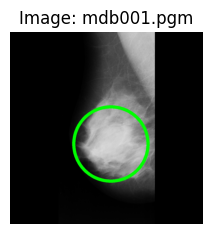

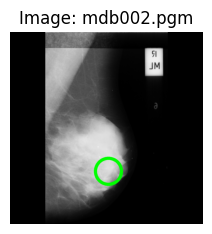

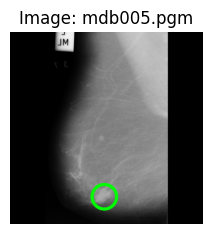

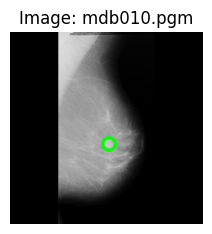

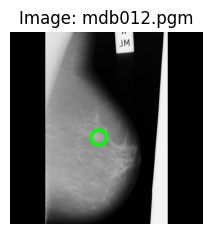

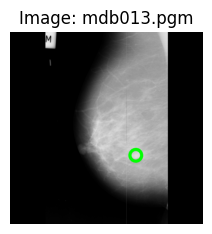

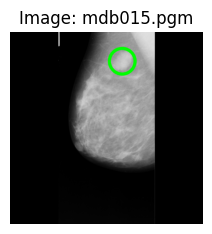

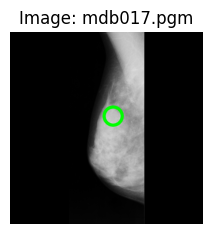

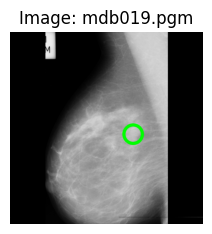

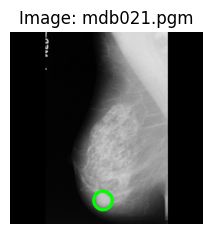

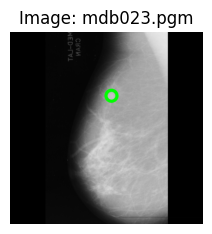

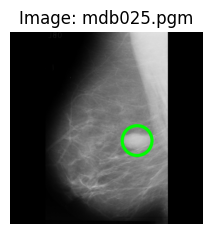

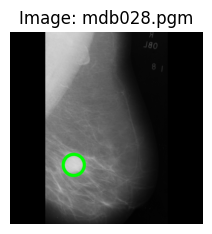

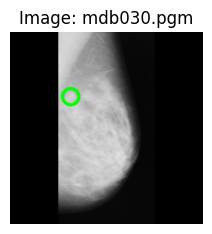

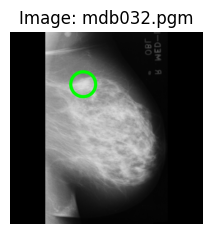

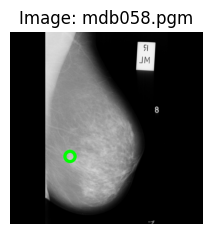

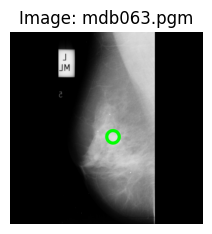

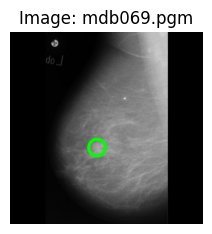

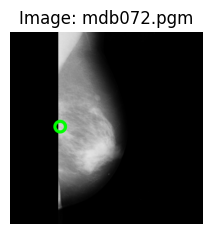

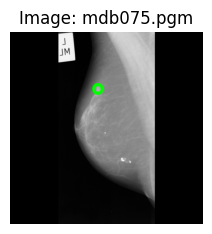

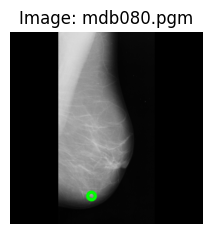

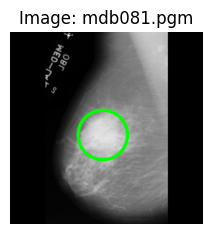

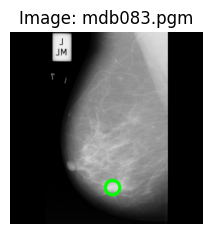

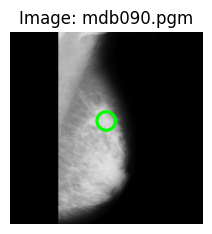

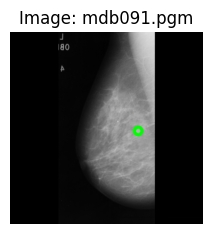

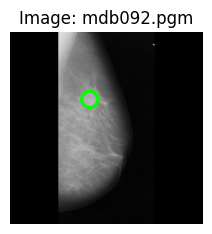

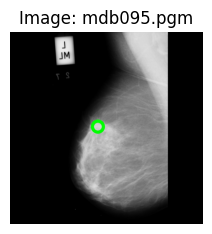

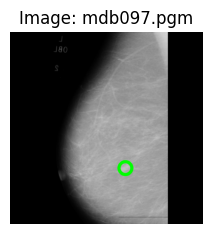

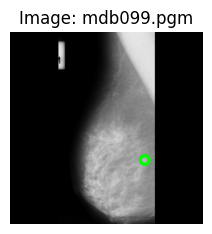

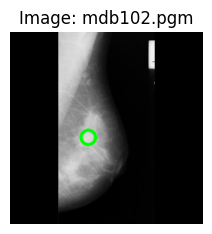

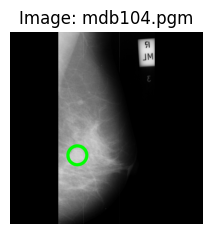

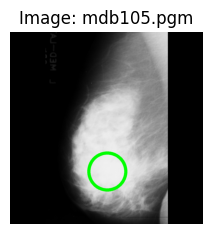

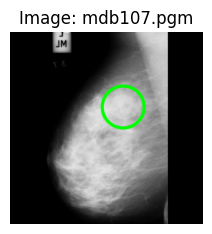

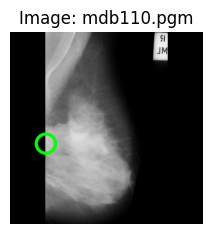

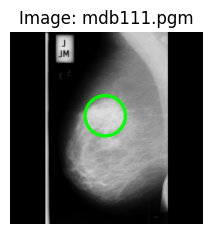

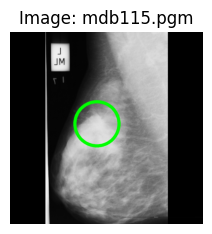

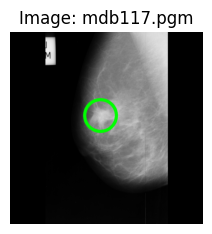

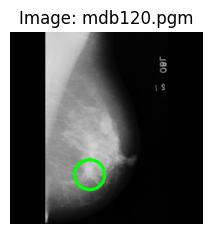

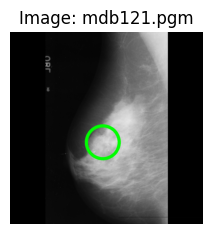

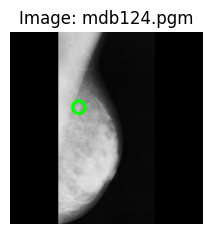

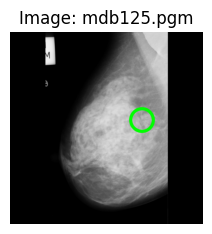

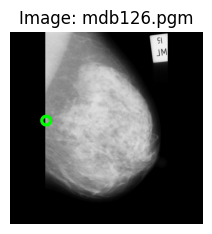

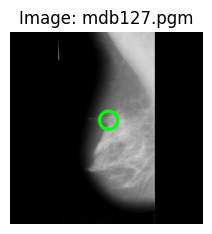

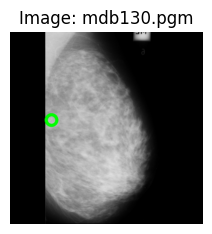

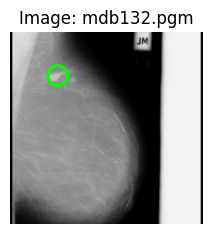

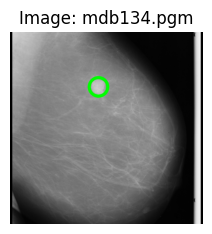

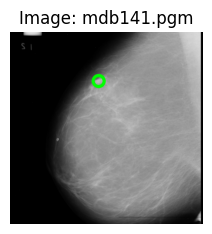

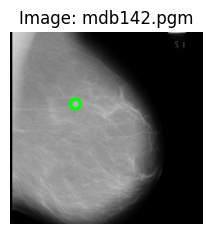

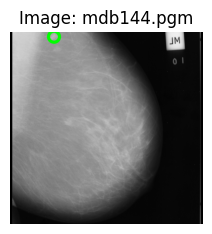

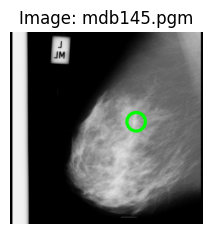

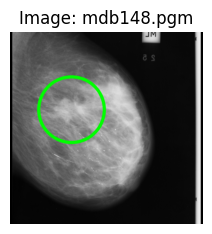

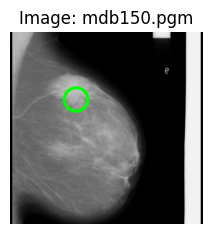

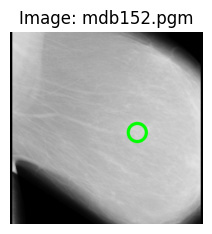

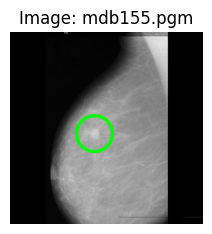

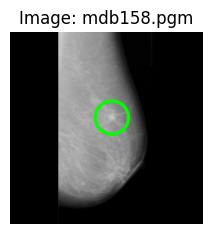

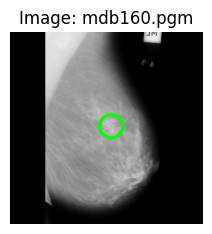

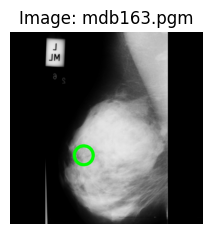

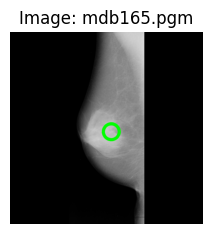

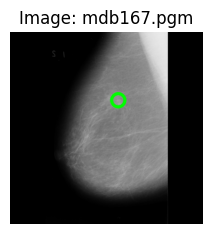

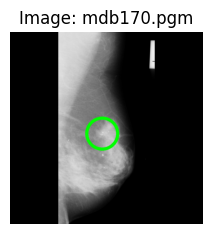

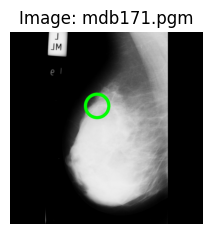

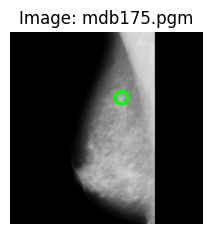

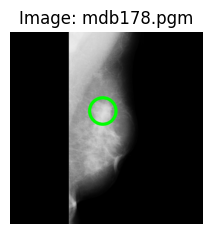

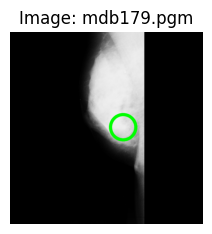

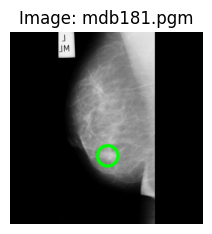

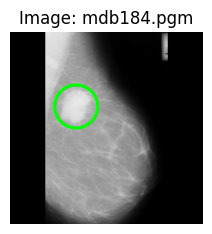

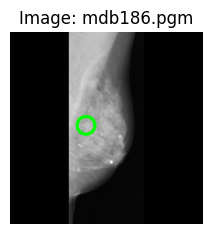

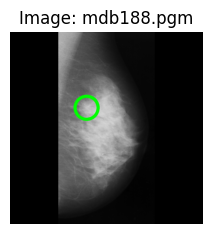

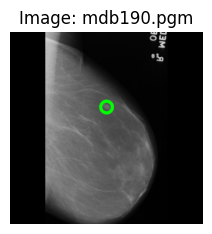

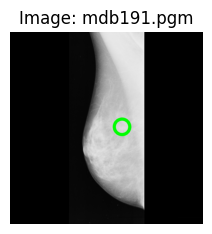

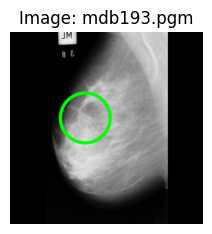

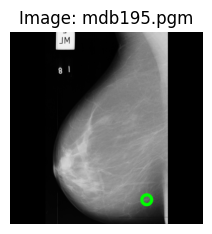

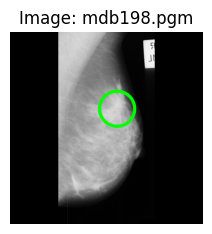

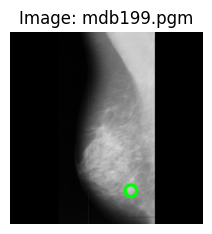

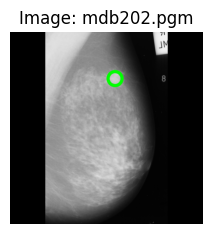

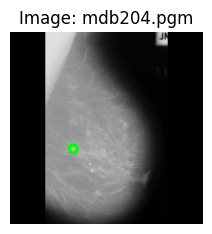

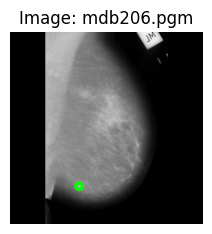

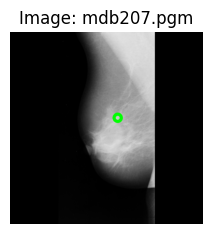

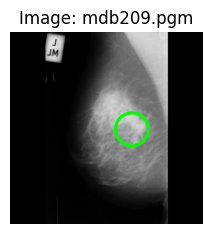

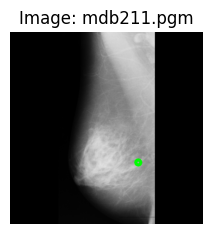

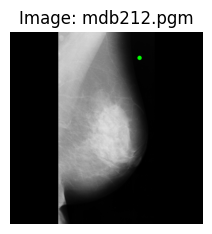

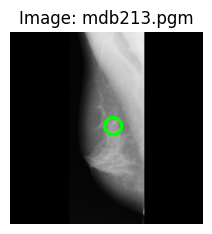

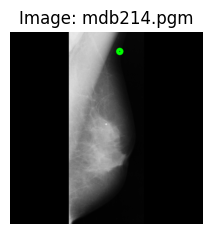

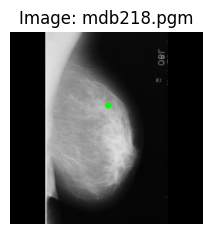

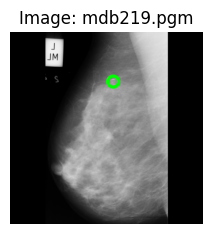

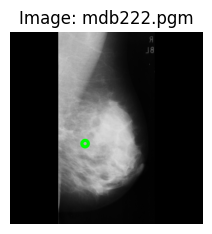

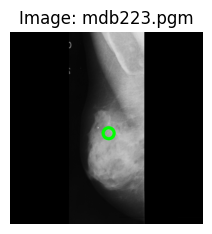

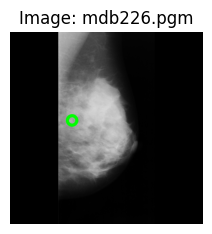

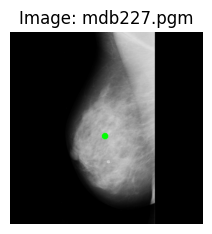

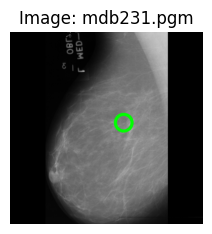

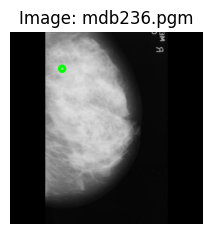

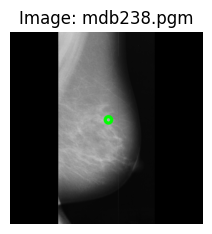

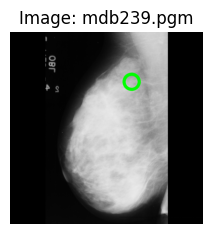

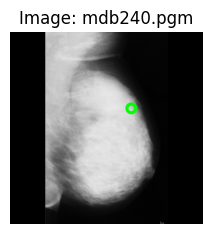

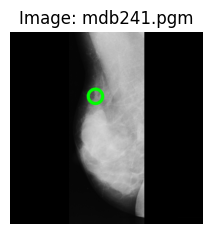

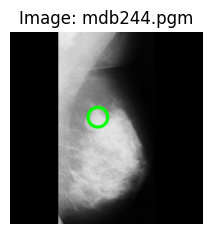

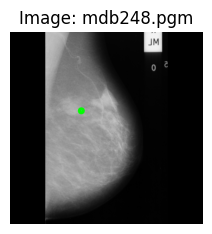

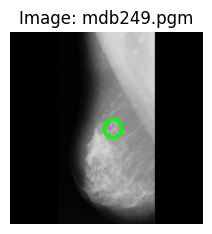

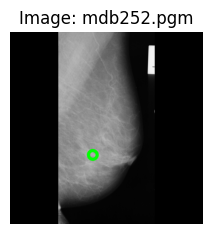

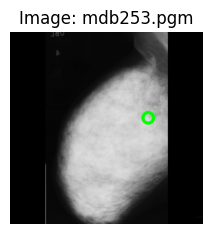

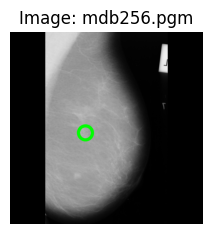

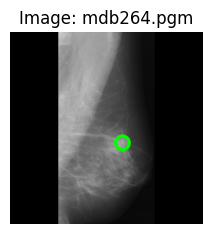

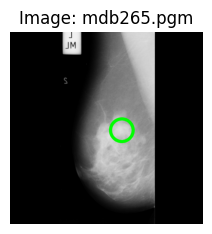

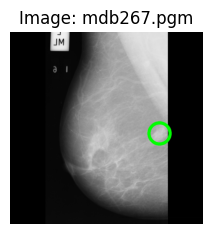

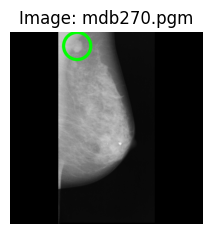

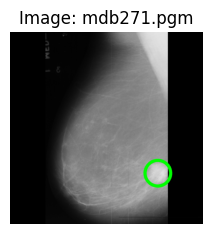

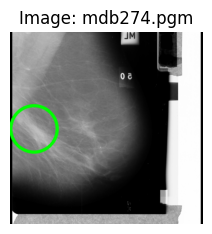

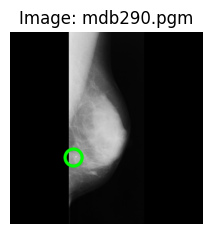

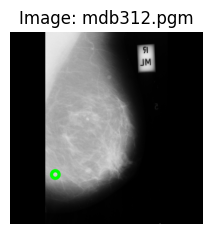

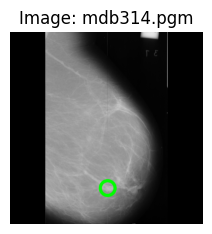

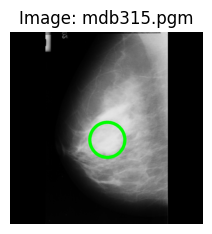

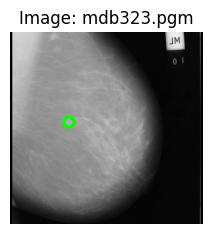

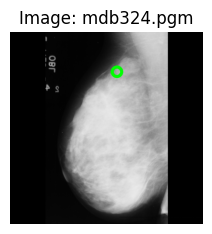

In [13]:
## 1. Load the DataFrame Correctly
# Use sep="\s+" to handle variable spaces, which is more robust.
# Provide column names directly to avoid issues with headers.
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)


## 2. The Corrected Data Labeling Function
def data_labeling(img_files_path, info_df):
    """
    Processes images by looking up their data in the DataFrame using a unique ID.
    """
    # Loop through each file in the image directory
    for filename in os.listdir(img_files_path):
        if filename.endswith(".pgm"):
            # Extract the unique ID (e.g., 'mdb001') from the filename
            base_refnum = os.path.splitext(filename)[0]

            # Use the ID to look up the correct row in the DataFrame
            record = info_df[info_df['REFNUM'] == base_refnum]

            # Proceed only if a matching record was found
            if not record.empty:
                image_path = os.path.join(img_files_path, filename)

                # Load the image and prepare it for drawing
                img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

                # Check if the record has coordinate data
                if pd.notna(record['X'].iloc[0]):
                    # Get data directly from the DataFrame columns
                    x = int(record['X'].iloc[0])
                    y = int(record['Y'].iloc[0])
                    r = int(record['RADIUS'].iloc[0])

                    # Draw the circle on the image
                    y_adj = 1024 - y  # Adjust y-coordinate
                    x = cv2.circle(img_rgb, (x, y_adj), r, (0, 255, 0), 15)

                    # You can now display it or save it
                    plt.figure(figsize=(2.5, 2.5))
                    plt.imshow(x)
                    plt.title(f"Image: {filename}")
                    plt.axis('off')
                    plt.show()


## 3. Call the Function Correctly
images_path = "all-mias"
# Pass the DataFrame to the function
data_labeling(images_path, df)

In [6]:

# --- 1. Set up Data Generators and Augmentation ---
# These will read images from your sorted folders
IMG_SIZE = (244, 244)
BATCH_SIZE = 32

# training the models based on different situation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    'dataset_for_training/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # For 'cancer' vs 'normal'
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset_for_training/validation/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# --- 2. Build the Model with Transfer Learning ---
# Load the pre-trained base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Freeze the base model's layers
base_model.trainable = False

# Add our custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) # Pool features to a manageable size
x = Dropout(0.5)(x) # Dropout to prevent overfitting
# The final prediction layer. 'sigmoid' is used for binary (0 or 1) classification.
predictions = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. Compile the Model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# --- 4. Train the Model ---
# This is where the training happens. It might take a while!
history = model.fit(
    train_generator,
    epochs=20, # Number of times to go through the entire dataset
    validation_data=validation_generator
)

# --- 5. Save your trained model ---
model.save('breast_cancer_classifier_v1.h5')

Found 256 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5906 - auc: 0.5097 - loss: 0.6826 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6621
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6377 - auc: 0.5328 - loss: 0.6574 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6539
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6434 - auc: 0.4842 - loss: 0.6527 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6530
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6164 - auc: 0.5298 - loss: 0.6676 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6533
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6839 - auc: 0.4494 - loss: 0.6294 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6538
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6609 - auc: 0.4503 - loss: 0.6447 - val_accuracy: 0.6406 - val_auc: 0.5870 - 

In [1]:
# def data_labeling(img_files, txt_path):
#     full_data = []
#     count_cancer = 0
#     img_coordinate = defaultdict(list)
#     pgm_index = 0
#     for i, filename in enumerate(sorted(os.listdir(img_files))):
#         if filename.endswith(".pgm"):
#             image_path = os.path.join(img_files, filename)
#             text = txt_file[i].strip()
#             pairing = {"Image": image_path, "Text": text}
#             pgm_index += 1
#             full_data.append(pairing)
#         else:
#             print(f"Not enough line in {filename}")
    
#     for pairing in full_data:
#         txt_value = pairing['Text']
#         img_value = pairing['Image']
#         img = cv2.imread(img_value)
#         txt_parts = txt_value.split()

#         if len(txt_parts) == 7 and img is not None:
#             count_cancer += 1
#             get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " +txt_parts[6] + " - " +img_value[9:]
#             # print(" x      y    R")
#             print(get_txt_data)
            
#             x = int(txt_parts[4])
#             y = 1024 - int(txt_parts[5])
#             radius = int(txt_parts[6])

#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
#             # Create a mask for the circular ROI
#             mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
#             cv2.circle(mask, (x, y), radius, 255, -1)  # Fill the circle with white
#             # Extract the circular ROI using the mask
#             roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
#             plt.imshow(img_rgb)
#             plt.show()

        
# # reading the Image file 
# images_path = "all-mias"

# # reading the txt file 
# txt_path = "data2.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()[1:]

# data_labeling(images_path, txt_path)

In [2]:
# def data_labeling(img_files, txt_path):
#     full_data = []
#     count_cancer = 0
#     pgm_index = 0  # This will index into txt_file
    
#     # Loop through image files sorted by name
#     for filename in sorted(os.listdir(img_files)):
#         if filename.endswith(".pgm"):
#             image_path = os.path.join(img_files, filename)
            
#             # Check if we have a corresponding text line
#             if pgm_index < len(txt_file):
#                 text = txt_file[pgm_index].strip()
#             else:
#                 print(f"Warning: Not enough text lines for {filename}")
#                 text = ""  # or handle the error as needed
            
#             pairing = {"Image": image_path, "Text": text}
#             full_data.append(pairing)
#             pgm_index += 1  # increment only when a .pgm file is processed

#     # Process each pairing
#     for pairing in full_data:
#         txt_value = pairing['Text']
#         img_value = pairing['Image']
#         img = cv2.imread(img_value)
#         txt_parts = txt_value.split()

#         if len(txt_parts) == 7 and img is not None:
#             count_cancer += 1
#             get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " + txt_parts[6] + " - " + img_value[9:]
#             print(get_txt_data)
            
#             x = int(txt_parts[4])
#             y = 1024 - int(txt_parts[5])
#             radius = int(txt_parts[6])

#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
#             mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
#             cv2.circle(mask, (x, y), radius, 255, -1)
#             roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
#             # Optionally display the image:
#             # plt.imshow(img_rgb)
#             # plt.show()

# # Reading the image files
# images_path = "all-mias"

# # Reading the text file and skipping the header
# txt_path = "data2.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()[1:]  # Skip the header line

# data_labeling(images_path, txt_path)


In [6]:
# ## FINDING THE REPEATED CORDINATION

# def data_labeling(img_files, txt_path):
#     full_data = []
#     count_cancer = 0
#     text_count = defaultdict(int)

#     # Reading image file paths and corresponding text values
#     for i, filename in enumerate(sorted(os.listdir(img_files))):
#         if filename.endswith(".pgm"):
#             image_path = os.path.join(img_files, filename)
#             text = txt_file[i].strip()

#             pairing = {"Image": image_path, "Text": text}
#             full_data.append(pairing)

#     # Iterate through the full_data, process each image and extract coordinates
#     for pairing in full_data:
#         txt_value = pairing['Text']
#         img_value = pairing['Image']
#         img = cv2.imread(img_value)
#         txt_parts = txt_value.split()
#         tokens = pairing['Text'].split()
#         txt_key = tokens[0]
#         text_count[txt_key] += 1
#     coordinates_dict = defaultdict(list)
    
#     for entry in full_data:
#         tokens = entry['Text'].split()
#         if len(tokens) > 3:
#             txt_key = tokens[0]  # Extract text key
#             # print(txt_key)
#             if text_count[txt_key] > 1:  # Only consider repeated text keys
#                 coords = list(map(int, tokens[-3:]))  # Extract last three as coordinates
#                 coordinates_dict[txt_key].append(coords)

#     for key, coords in coordinates_dict.items():
#         print(f"{key}: {coords}")

# # Reading the image file paths
# images_path = "all-mias"

# # Reading the txt file
# txt_path = "data2.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()

# # Run the data labeling function
# data_labeling(images_path, txt_path)


   REFNUM BG CLASS SEVERITY      X      Y  RADIUS
0  mdb001  G  CIRC        B  535.0  425.0   197.0
1  mdb002  G  CIRC        B  522.0  280.0    69.0
2  mdb003  D  NORM      NaN    NaN    NaN     NaN
3  mdb004  D  NORM      NaN    NaN    NaN     NaN
4  mdb005  F  CIRC        B  477.0  133.0    30.0


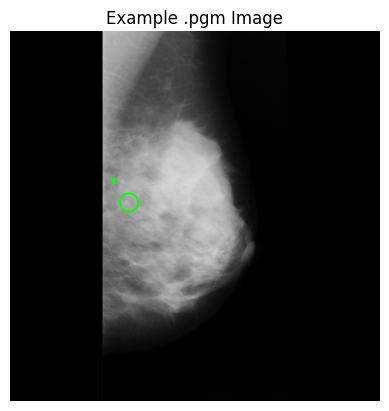

In [42]:
# # Read the image file
# img_file = "all-mias/mdb226.pgm"
# img_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
# img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

# # Read the text file
# with open("info.txt", "r") as file:
#     txt_lines = file.readlines()

# # Read the CSV file
# df = pd.read_csv("Info.txt", sep=" ").drop("Unnamed: 7", axis=1)
# print(df.head(5))

# # Example data: list of [x, y, radius]
# mdb144 = [[287, 610, 7], [329, 550, 25]]
# # Sort by the last element (assumed to be the radius)
# sorted_mdb = sorted(mdb144, key=lambda item: item[-1])

# # Draw a circle for each detection
# for x, y, r in sorted_mdb:
#     y_adj = 1024 - y  # adjust y-coordinate
#     cv2.circle(img_rgb, (x, y_adj), r, (0, 255, 0), 3)

# # Create a mask and region of interest using the first detection (if available)
# if sorted_mdb:
#     x, y, r = sorted_mdb[0]
#     y_adj = 1024 - y
#     mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y_adj), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# # Display the result
# plt.imshow(img_rgb, cmap='gray')
# plt.title("Example .pgm Image")
# plt.axis('off')  # Hide axis ticks
# plt.show()


In [3]:
# # reading the Image file 
# # img_files = glob.glob("all-mias")
# img_files_test = "all-mias/mdb226.pgm"
# # print(f"found {len(img_files)} .pmg images")

# # reading the txt file 
# txt_path = "info.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()

# df = pd.read_csv('Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
# df.head(5)

    
# img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
# img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)
# # x, y, radius = 535, 425, 197
# # custom_list = {}
# mdb144 = [[287, 610, 7], [329, 550, 25], [531, 721, 8]]
# # mdb144 = [[233, 994, 29], [313, 540, 27]]
# # mdb144 = [[522, 280, 69]]


# if len(mdb144) == 1:
#     sorted_mdb = sorted(mdb144, key= lambda item: item[-1])
#     x, y, r = mdb144[0]
#     y = 1024 - y
#     cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
#     mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

#     plt.imshow(img_rgb_t, cmap='gray')
#     plt.title("Example .pgm Image")
#     plt.axis('off')  # Hide axis ticks
#     plt.show()

# elif len(mdb144) == 2:
#     sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
#     for i in range(len(sorted_mdb)):
#         x, y, r = sorted_mdb[i]
#         y = 1024-y
#         if len(sorted_mdb) > 1:
#             x2, y2, r2 = sorted_mdb[0]
#             y2 = 1024-y2
#     cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
#     cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2) 
#     mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

#     plt.imshow(img_rgb_t, cmap='gray')
#     plt.title("Example .pgm Image")
#     plt.axis('off')  # Hide axis ticks
#     plt.show()

# elif len(mdb144) == 3:
#     sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
#     for i in range(len(sorted_mdb)):
#         x, y, r = sorted_mdb[i]
#         y = 1024-y
#         if len(sorted_mdb) > 1:
#             x2, y2, r2 = sorted_mdb[1]
#             y2 = 1024-y2
#             x3, y3, r3 = sorted_mdb[0]
#             y3 = 1024-y3
#     cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
#     cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2)
#     cv2.circle(img_rgb_t, (x3,y3), r3, (0, 255, 0), 2)
#     mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

#     plt.imshow(img_rgb_t, cmap='gray')
#     plt.title("Example .pgm Image")
#     plt.axis('off')  # Hide axis ticks
#     plt.show()


In [4]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Read image file
# img_files_test = "all-mias/mdb144.pgm"
# img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
# img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)

# # Example mdb144 data (x, y, radius)
# mdb144 = [[233, 994, 29], [313, 540, 27]]

# # Sort list by the y-coordinate (second element)
# sorted_mdb = sorted(mdb144, key=lambda item: item[1])

# # Process the first sublist
# if len(sorted_mdb) >= 1:
#     x, y, r = sorted_mdb[0]
#     y_adj = y - 1024  # Adjust y-coordinate if necessary
#     cv2.circle(img_rgb_t, (x, y_adj), r, (0, 255, 0), 2)
#     # Overlay coordinate text
#     cv2.putText(img_rgb_t, f"({x}, {y_adj})", (x, y_adj), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# # Process the second sublist if available
# if len(sorted_mdb) >= 2:
#     x2, y2, r2 = sorted_mdb[1]
#     y2_adj = y2 - 1024  # Adjust y-coordinate if necessary
#     cv2.circle(img_rgb_t, (x2, y2_adj), r2, (0, 255, 0), 2)
#     # Overlay coordinate text
#     cv2.putText(img_rgb_t, f"({x2}, {y2_adj})", (x2, y2_adj), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# # Create a mask using the first circle's parameters (if needed)
# mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
# cv2.circle(mask, (x, y - 1024), r, 255, -1)
# roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

# # Display the result
# plt.imshow(img_rgb_t)
# plt.title("Example .pgm Image")
# plt.axis('off')  # Hide axis ticks
# plt.show()


Exception: File `'lbp_glcm_pipeline.py'` not found.

In [18]:
#!/usr/bin/env python3
"""
lbp_glcm_pipeline.py

Usage (example):
    python lbp_glcm_pipeline.py --images /path/to/all-mias --meta data2.txt --outdir results

Output:
 - features.pkl    (X, y, groups)
 - report.json     (summary, CV metrics, permutation p-value)
 - sample_rois.png (6 sample ROI images)
"""

import os
import argparse
import json
import pickle
import time
import math
import numpy as np
import pandas as pd
import cv2
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import permutation_test_score

# --------------------------
# Helper functions
# --------------------------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    # Try to read skipping header if present
    try:
        df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=0)
    except Exception:
        df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    # numeric part and patient grouping (mdb001/mdb002 => same patient)
    def extract_num(ref):
        try:
            return int(ref[3:])
        except Exception:
            return None
    df['num'] = df['REFNUM'].map(extract_num)
    df['patient_id'] = df['num'].apply(lambda n: None if pd.isna(n) else ((n-1)//2 + 1))
    return df

def preprocess_img(img):
    # expects grayscale uint8
    if img is None:
        raise ValueError("None image passed to preprocess_img")
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img)
    return img_eq

def roi_from_row(img_eq, row, image_size=1024, median_radius=48, min_side=32):
    """
    Return a square ROI (numpy array) for the record row.
    - If row has X/Y/RADIUS and CANCER==1 => crop center at (X, image_size - Y) with side 2*radius
    - Else => crop center at image center with side 2*median_radius
    Pads if too small and returns ROI.
    """
    label = int(row['CANCER'])
    x = row['X']; y = row['Y']; radius = row['RADIUS']
    H, W = img_eq.shape
    if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(radius):
        cx = int(x)
        cy = int(image_size - float(y))  # MIAS bottom-left -> convert to top-left
        r = int(radius)
        x0 = max(0, cx - r); x1 = min(W, cx + r)
        y0 = max(0, cy - r); y1 = min(H, cy + r)
        roi = img_eq[y0:y1, x0:x1]
        if roi.size == 0:
            roi = img_eq.copy()
    else:
        r = int(median_radius)
        cx, cy = W // 2, H // 2
        x0 = max(0, cx - r); x1 = min(W, cx + r)
        y0 = max(0, cy - r); y1 = min(H, cy + r)
        roi = img_eq[y0:y1, x0:x1]

    # pad if too small
    h, w = roi.shape
    if h < min_side or w < min_side:
        top = max(0, (min_side - h) // 2); bottom = max(0, min_side - h - top)
        left = max(0, (min_side - w) // 2); right = max(0, min_side - w - left)
        roi = cv2.copyMakeBorder(roi, top, bottom, left, right, cv2.BORDER_REFLECT)
    return roi

def extract_features_from_roi(roi, target_size=128, P=8, R=3, n_bins=59):
    # Resize ROI to target_size x target_size
    roi_resized = cv2.resize(roi, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # LBP (uniform)
    lbp = feature.local_binary_pattern(roi_resized, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(float) / (hist.sum() + 1e-10)
    # GLCM
    glcm = graycomatrix(roi_resized,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256,
                        symmetric=True,
                        normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    glcm_feats = [float(graycoprops(glcm, p).mean()) for p in props]
    feats = np.concatenate([hist, np.array(glcm_feats, dtype=float)])
    return feats, roi_resized

def convert(o):
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    return str(o)

# --------------------------
# Main pipeline
# --------------------------
def main(args):

    images_path = "all-mias"
    start_all = time.time()
    df = read_metadata("data2.txt")
    print(f"[INFO] Metadata rows: {len(df)}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # list images
    images = sorted([f for f in os.listdir(images_path) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(images)} image files in {images_path}")

    features = []
    labels = []
    groups = []
    sample_rois = []

    # process images in chunks to avoid memory spikes
    refs = [os.path.splitext(f)[0] for f in images]
    total = len(refs)
    chunk = args.chunk
    for i in range(0, total, chunk):
        chunk_refs = refs[i:i+chunk]
        print(f"[INFO] Processing chunk {i//chunk + 1} / {math.ceil(total/chunk)} (size {len(chunk_refs)})")
        for ref in chunk_refs:
            row = df[df['REFNUM'] == ref]
            if row.empty:
                # skip if metadata not found
                continue
            row = row.iloc[0]
            img_path = os.path.join(images_path, ref + ".pgm")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARN] cannot read {img_path}, skipping")
                continue
            try:
                img_eq = preprocess_img(img)
                roi = roi_from_row(img_eq, row, image_size=args.image_size, median_radius=median_radius, min_side=args.min_side)
                feats, roi_resized = extract_features_from_roi(roi, target_size=args.target_size,
                                                               P=args.P, R=args.R, n_bins=args.n_bins)
                features.append(feats)
                labels.append(int(row['CANCER']))
                groups.append(row['patient_id'])
                if len(sample_rois) < 6:
                    sample_rois.append((ref, int(row['CANCER']), row['patient_id'], roi_resized))
            except Exception as e:
                print(f"[ERROR] processing {ref}: {e}")

    X = np.vstack(features) if len(features) > 0 else np.zeros((0, args.n_bins + 5))
    y = np.array(labels)
    groups_arr = np.array(groups)

    print("[INFO] Extracted features shape:", X.shape)
    # Save features
    os.makedirs(args.outdir, exist_ok=True)
    with open(os.path.join(args.outdir, "features.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr}, f)
    print("[INFO] Saved features.pkl")

    # Save sample ROI visualization
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,4))
    for idx, (ref, lab, grp, roi_img) in enumerate(sample_rois):
        ax = fig.add_subplot(2, 3, idx+1)
        ax.imshow(roi_img, cmap='gray'); ax.set_title(f"{ref} L={lab} G={grp}"); ax.axis('off')
    fig.tight_layout()
    fig.savefig(os.path.join(args.outdir, "sample_rois.png"))
    plt.close(fig)

    # ----------------
    # Group-aware CV: RF, SVM, KNN
    # ----------------
    n_groups = len(set([g for g in groups_arr if g is not None]))
    n_splits = min(5, max(2, n_groups))  # fallback
    print(f"[INFO] Running GroupKFold with n_splits={n_splits} (unique groups: {n_groups})")

    gk = GroupKFold(n_splits=n_splits)
    scaler = StandardScaler()
    rf = RandomForestClassifier(n_estimators=args.rf_estimators, random_state=42, class_weight='balanced', n_jobs=args.n_jobs)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)

    cv_results = {"rf": [], "svm": [], "knn": []}
    fold = 0
    for train_idx, test_idx in gk.split(X, y, groups_arr):
        fold += 1
        Xtr, Xte = X[train_idx], X[test_idx]; ytr, yte = y[train_idx], y[test_idx]
        Xtr = scaler.fit_transform(Xtr); Xte = scaler.transform(Xte)
        # RF
        rf.fit(Xtr, ytr)
        ypred_rf = rf.predict(Xte); yprob_rf = rf.predict_proba(Xte)[:,1]
        acc_rf = accuracy_score(yte, ypred_rf); rec_rf = recall_score(yte, ypred_rf, zero_division=0)
        auc_rf = roc_auc_score(yte, yprob_rf) if len(np.unique(yte))>1 else float('nan')
        cv_results['rf'].append((acc_rf, rec_rf, auc_rf, int(sum(yte==1))))
        # SVM
        try:
            svm.fit(Xtr, ytr)
            ypred_svm = svm.predict(Xte); yprob_svm = svm.predict_proba(Xte)[:,1]
            acc_svm = accuracy_score(yte, ypred_svm); rec_svm = recall_score(yte, ypred_svm, zero_division=0)
            auc_svm = roc_auc_score(yte, yprob_svm) if len(np.unique(yte))>1 else float('nan')
        except Exception:
            acc_svm = rec_svm = auc_svm = float('nan')
        cv_results['svm'].append((acc_svm, rec_svm, auc_svm, int(sum(yte==1))))
        # KNN
        try:
            knn.fit(Xtr, ytr)
            ypred_knn = knn.predict(Xte); yprob_knn = knn.predict_proba(Xte)[:,1]
            acc_knn = accuracy_score(yte, ypred_knn); rec_knn = recall_score(yte, ypred_knn, zero_division=0)
            auc_knn = roc_auc_score(yte, yprob_knn) if len(np.unique(yte))>1 else float('nan')
        except Exception:
            acc_knn = rec_knn = auc_knn = float('nan')
        cv_results['knn'].append((acc_knn, rec_knn, auc_knn, int(sum(yte==1))))
        print(f"[FOLD {fold}] RF acc={acc_rf:.3f} rec={rec_rf:.3f} auc={auc_rf:.3f} pos={sum(yte==1)}")

    # summarize
    def summarize(results):
        arr = np.array([[r[0] if not np.isnan(r[0]) else np.nan, r[1] if not np.isnan(r[1]) else np.nan, r[2] if not np.isnan(r[2]) else np.nan] for r in results], dtype=float)
        mean_vals = np.nanmean(arr, axis=0).tolist()
        return {"mean_acc": mean_vals[0], "mean_rec": mean_vals[1], "mean_auc": mean_vals[2], "per_fold": results}

    summary = {
        "n_samples": int(X.shape[0]),
        "n_features": int(X.shape[1]),
        "label_counts": dict(pd.Series(y).value_counts()),
        "unique_groups": int(len(set(groups_arr))),
        "cv_rf": summarize(cv_results['rf']),
        "cv_svm": summarize(cv_results['svm']),
        "cv_knn": summarize(cv_results['knn']),
        "elapsed_seconds": time.time() - start_all
    }

    # Permutation test (on RF)
    print("[INFO] Running permutation test (this can take several minutes)...")
    # create GroupShuffleSplit held out split for final evaluation then run permutation on training set
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups_arr))
    Xtr_full, Xte_full = X[train_idx], X[test_idx]; ytr_full, yte_full = y[train_idx], y[test_idx]
    Xtr_full = scaler.fit_transform(Xtr_full); Xte_full = scaler.transform(Xte_full)
    rf.fit(Xtr_full, ytr_full)
    held_acc = accuracy_score(yte_full, rf.predict(Xte_full))
    try:
        perm_score, perm_scores, pvalue = permutation_test_score(rf, Xtr_full, ytr_full, cv=5, n_permutations=args.n_permutations, n_jobs=args.n_jobs, scoring='accuracy')
    except Exception:
        perm_score, perm_scores, pvalue = float('nan'), [], float('nan')

    summary.update({"held_out_acc": float(held_acc), "perm_pvalue": float(pvalue), "perm_score": float(perm_score)})
    # save report
    with open(os.path.join(args.outdir, "report.json"), "w") as f:
        json.dump(summary, f, indent=2, default=convert)
    # save final features too
    with open(os.path.join(args.outdir, "features.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr}, f)

    print("[INFO] Done. Summary:")
    print(json.dumps(summary, indent=2, default=convert))

# --------------------------
# CLI arguments
# --------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="LBP + GLCM pipeline for MIAS")
    parser.add_argument("--images", required=True, help="all-mias")
    parser.add_argument("--meta", required=True, help="data2.txt")
    parser.add_argument("--outdir", default="results", help="Folder to save features/report")
    parser.add_argument("--target_size", type=int, default=128, help="Resize ROIs to this size")
    parser.add_argument("--min_side", type=int, default=32, help="Minimum ROI side (pad if smaller)")
    parser.add_argument("--image_size", type=int, default=1024, help="Original image size (MIAS default 1024)")
    parser.add_argument("--chunk", type=int, default=100, help="Process images in chunks to avoid memory spikes")
    parser.add_argument("--P", type=int, default=8, help="LBP P")
    parser.add_argument("--R", type=int, default=3, help="LBP R")
    parser.add_argument("--n_bins", type=int, default=59, help="LBP histogram bins (uniform P=8 -> 59)")
    parser.add_argument("--rf_estimators", type=int, default=300, help="Random forest n_estimators")
    parser.add_argument("--n_jobs", type=int, default=-1, help="n_jobs for model training / permutation")
    parser.add_argument("--n_permutations", type=int, default=50, help="Permutation test permutations")
    args = parser.parse_args()
    main(args)


[INFO] Metadata rows: 324
[INFO] median radius: 43
[INFO] Found 324 image files in all-mias
[INFO] Processing chunk 1 / 4 (size 100)
[INFO] Processing chunk 2 / 4 (size 100)
[INFO] Processing chunk 3 / 4 (size 100)
[INFO] Processing chunk 4 / 4 (size 24)
[INFO] Extracted features shape: (324, 64)
[INFO] Saved features.pkl
[INFO] Running GroupKFold with n_splits=5 (unique groups: 162)
[FOLD 1] RF acc=0.864 rec=0.741 auc=0.923 pos=27
[FOLD 2] RF acc=0.727 rec=0.500 auc=0.779 pos=26
[FOLD 3] RF acc=0.844 rec=0.591 auc=0.865 pos=22
[FOLD 4] RF acc=0.812 rec=0.667 auc=0.846 pos=24
[FOLD 5] RF acc=0.844 rec=0.611 auc=0.873 pos=18
[INFO] Running permutation test (this can take several minutes)...
[INFO] Done. Summary:
{
  "n_samples": 324,
  "n_features": 64,
  "label_counts": {
    "0": 207,
    "1": 117
  },
  "unique_groups": 162,
  "cv_rf": {
    "mean_acc": 0.8181818181818181,
    "mean_rec": 0.6218855218855219,
    "mean_auc": 0.8571172669587526,
    "per_fold": [
      [
        0.8636

In [16]:
#!/usr/bin/env python3
"""
lbp_glcm_pipeline.py

Usage (example):
    python lbp_glcm_pipeline.py --images /path/to/all-mias --meta data2.txt --outdir results

Output:
 - features.pkl    (X, y, groups)
 - report.json     (summary, CV metrics, permutation p-value)
 - sample_rois.png (6 sample ROI images)
"""

import os
import argparse
import json
import pickle
import time
import math
import numpy as np
import pandas as pd
import cv2
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import permutation_test_score

# --------------------------
# Helper functions
# --------------------------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    # Try to read skipping header if present
    try:
        df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=0)
    except Exception:
        df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    # numeric part and patient grouping (mdb001/mdb002 => same patient)
    def extract_num(ref):
        try:
            return int(ref[3:])
        except Exception:
            return None
    df['num'] = df['REFNUM'].map(extract_num)
    df['patient_id'] = df['num'].apply(lambda n: None if pd.isna(n) else ((n-1)//2 + 1))
    return df

def preprocess_img(img):
    # expects grayscale uint8
    if img is None:
        raise ValueError("None image passed to preprocess_img")
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img)
    return img_eq

def roi_from_row(img_eq, row, image_size=1024, median_radius=48, min_side=32):
    """
    Return a square ROI (numpy array) for the record row.
    - If row has X/Y/RADIUS and CANCER==1 => crop center at (X, image_size - Y) with side 2*radius
    - Else => crop center at image center with side 2*median_radius
    Pads if too small and returns ROI.
    """
    label = int(row['CANCER'])
    x = row['X']; y = row['Y']; radius = row['RADIUS']
    H, W = img_eq.shape
    if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(radius):
        cx = int(x)
        cy = int(image_size - float(y))  # MIAS bottom-left -> convert to top-left
        r = int(radius)
        x0 = max(0, cx - r); x1 = min(W, cx + r)
        y0 = max(0, cy - r); y1 = min(H, cy + r)
        roi = img_eq[y0:y1, x0:x1]
        if roi.size == 0:
            roi = img_eq.copy()
    else:
        r = int(median_radius)
        cx, cy = W // 2, H // 2
        x0 = max(0, cx - r); x1 = min(W, cx + r)
        y0 = max(0, cy - r); y1 = min(H, cy + r)
        roi = img_eq[y0:y1, x0:x1]

    # pad if too small
    h, w = roi.shape
    if h < min_side or w < min_side:
        top = max(0, (min_side - h) // 2); bottom = max(0, min_side - h - top)
        left = max(0, (min_side - w) // 2); right = max(0, min_side - w - left)
        roi = cv2.copyMakeBorder(roi, top, bottom, left, right, cv2.BORDER_REFLECT)
    return roi

def extract_features_from_roi(roi, target_size=128, P=8, R=3, n_bins=59):
    # Resize ROI to target_size x target_size
    roi_resized = cv2.resize(roi, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # LBP (uniform)
    lbp = feature.local_binary_pattern(roi_resized, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(float) / (hist.sum() + 1e-10)
    # GLCM
    glcm = graycomatrix(roi_resized,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256,
                        symmetric=True,
                        normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    glcm_feats = [float(graycoprops(glcm, p).mean()) for p in props]
    feats = np.concatenate([hist, np.array(glcm_feats, dtype=float)])
    return feats, roi_resized

def convert(o):
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    return str(o)

# --------------------------
# Main pipeline
# --------------------------
def main(args):

    images_path = "all-mias"
    start_all = time.time()
    df = read_metadata("data2.txt")
    print(f"[INFO] Metadata rows: {len(df)}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # list images
    images = sorted([f for f in os.listdir(images_path) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(images)} image files in {images_path}")

    features = []
    labels = []
    groups = []
    sample_rois = []

    # process images in chunks to avoid memory spikes
    refs = [os.path.splitext(f)[0] for f in images]
    total = len(refs)
    chunk = args.chunk
    for i in range(0, total, chunk):
        chunk_refs = refs[i:i+chunk]
        print(f"[INFO] Processing chunk {i//chunk + 1} / {math.ceil(total/chunk)} (size {len(chunk_refs)})")
        for ref in chunk_refs:
            row = df[df['REFNUM'] == ref]
            if row.empty:
                # skip if metadata not found
                continue
            row = row.iloc[0]
            img_path = os.path.join(images_path, ref + ".pgm")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARN] cannot read {img_path}, skipping")
                continue
            try:
                img_eq = preprocess_img(img)
                roi = roi_from_row(img_eq, row, image_size=args.image_size, median_radius=median_radius, min_side=args.min_side)
                feats, roi_resized = extract_features_from_roi(roi, target_size=args.target_size,
                                                               P=args.P, R=args.R, n_bins=args.n_bins)
                features.append(feats)
                labels.append(int(row['CANCER']))
                groups.append(row['patient_id'])
                if len(sample_rois) < 6:
                    sample_rois.append((ref, int(row['CANCER']), row['patient_id'], roi_resized))
            except Exception as e:
                print(f"[ERROR] processing {ref}: {e}")

    X = np.vstack(features) if len(features) > 0 else np.zeros((0, args.n_bins + 5))
    y = np.array(labels)
    groups_arr = np.array(groups)

    print("[INFO] Extracted features shape:", X.shape)
    # Save features
    os.makedirs(args.outdir, exist_ok=True)
    with open(os.path.join(args.outdir, "features.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr}, f)
    print("[INFO] Saved features.pkl")

    # Save sample ROI visualization
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,4))
    for idx, (ref, lab, grp, roi_img) in enumerate(sample_rois):
        ax = fig.add_subplot(2, 3, idx+1)
        ax.imshow(roi_img, cmap='gray'); ax.set_title(f"{ref} L={lab} G={grp}"); ax.axis('off')
    fig.tight_layout()
    fig.savefig(os.path.join(args.outdir, "sample_rois.png"))
    plt.close(fig)

    # ----------------
    # Group-aware CV: RF, SVM, KNN
    # ----------------
    n_groups = len(set([g for g in groups_arr if g is not None]))
    n_splits = min(5, max(2, n_groups))  # fallback
    print(f"[INFO] Running GroupKFold with n_splits={n_splits} (unique groups: {n_groups})")

    gk = GroupKFold(n_splits=n_splits)
    scaler = StandardScaler()
    rf = RandomForestClassifier(n_estimators=args.rf_estimators, random_state=42, class_weight='balanced', n_jobs=args.n_jobs)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)

    cv_results = {"rf": [], "svm": [], "knn": []}
    fold = 0
    for train_idx, test_idx in gk.split(X, y, groups_arr):
        fold += 1
        Xtr, Xte = X[train_idx], X[test_idx]; ytr, yte = y[train_idx], y[test_idx]
        Xtr = scaler.fit_transform(Xtr); Xte = scaler.transform(Xte)
        # RF
        rf.fit(Xtr, ytr)
        ypred_rf = rf.predict(Xte); yprob_rf = rf.predict_proba(Xte)[:,1]
        acc_rf = accuracy_score(yte, ypred_rf); rec_rf = recall_score(yte, ypred_rf, zero_division=0)
        auc_rf = roc_auc_score(yte, yprob_rf) if len(np.unique(yte))>1 else float('nan')
        cv_results['rf'].append((acc_rf, rec_rf, auc_rf, int(sum(yte==1))))
        # SVM
        try:
            svm.fit(Xtr, ytr)
            ypred_svm = svm.predict(Xte); yprob_svm = svm.predict_proba(Xte)[:,1]
            acc_svm = accuracy_score(yte, ypred_svm); rec_svm = recall_score(yte, ypred_svm, zero_division=0)
            auc_svm = roc_auc_score(yte, yprob_svm) if len(np.unique(yte))>1 else float('nan')
        except Exception:
            acc_svm = rec_svm = auc_svm = float('nan')
        cv_results['svm'].append((acc_svm, rec_svm, auc_svm, int(sum(yte==1))))
        # KNN
        try:
            knn.fit(Xtr, ytr)
            ypred_knn = knn.predict(Xte); yprob_knn = knn.predict_proba(Xte)[:,1]
            acc_knn = accuracy_score(yte, ypred_knn); rec_knn = recall_score(yte, ypred_knn, zero_division=0)
            auc_knn = roc_auc_score(yte, yprob_knn) if len(np.unique(yte))>1 else float('nan')
        except Exception:
            acc_knn = rec_knn = auc_knn = float('nan')
        cv_results['knn'].append((acc_knn, rec_knn, auc_knn, int(sum(yte==1))))
        print(f"[FOLD {fold}] RF acc={acc_rf:.3f} rec={rec_rf:.3f} auc={auc_rf:.3f} pos={sum(yte==1)}")

    # summarize
    def summarize(results):
        arr = np.array([[r[0] if not np.isnan(r[0]) else np.nan, r[1] if not np.isnan(r[1]) else np.nan, r[2] if not np.isnan(r[2]) else np.nan] for r in results], dtype=float)
        mean_vals = np.nanmean(arr, axis=0).tolist()
        return {"mean_acc": mean_vals[0], "mean_rec": mean_vals[1], "mean_auc": mean_vals[2], "per_fold": results}

    summary = {
        "n_samples": int(X.shape[0]),
        "n_features": int(X.shape[1]),
        "label_counts": dict(pd.Series(y).value_counts()),
        "unique_groups": int(len(set(groups_arr))),
        "cv_rf": summarize(cv_results['rf']),
        "cv_svm": summarize(cv_results['svm']),
        "cv_knn": summarize(cv_results['knn']),
        "elapsed_seconds": time.time() - start_all
    }

    # Permutation test (on RF)
    print("[INFO] Running permutation test (this can take several minutes)...")
    # create GroupShuffleSplit held out split for final evaluation then run permutation on training set
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups_arr))
    Xtr_full, Xte_full = X[train_idx], X[test_idx]; ytr_full, yte_full = y[train_idx], y[test_idx]
    Xtr_full = scaler.fit_transform(Xtr_full); Xte_full = scaler.transform(Xte_full)
    rf.fit(Xtr_full, ytr_full)
    held_acc = accuracy_score(yte_full, rf.predict(Xte_full))
    try:
        perm_score, perm_scores, pvalue = permutation_test_score(rf, Xtr_full, ytr_full, cv=5, n_permutations=args.n_permutations, n_jobs=args.n_jobs, scoring='accuracy')
    except Exception:
        perm_score, perm_scores, pvalue = float('nan'), [], float('nan')

    summary.update({"held_out_acc": float(held_acc), "perm_pvalue": float(pvalue), "perm_score": float(perm_score)})
    # save report
    with open(os.path.join(args.outdir, "report.json"), "w") as f:
        json.dump(summary, f, indent=2, default=convert)
    # save final features too
    with open(os.path.join(args.outdir, "features.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr}, f)

    print("[INFO] Done. Summary:")
    print(json.dumps(summary, indent=2))

# --------------------------
# CLI arguments
# --------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="LBP + GLCM pipeline for MIAS")
    parser.add_argument("--images", required=True, help="all-mias")
    parser.add_argument("--meta", required=True, help="data2.txt")
    parser.add_argument("--outdir", default="results", help="Folder to save features/report")
    parser.add_argument("--target_size", type=int, default=128, help="Resize ROIs to this size")
    parser.add_argument("--min_side", type=int, default=32, help="Minimum ROI side (pad if smaller)")
    parser.add_argument("--image_size", type=int, default=1024, help="Original image size (MIAS default 1024)")
    parser.add_argument("--chunk", type=int, default=100, help="Process images in chunks to avoid memory spikes")
    parser.add_argument("--P", type=int, default=8, help="LBP P")
    parser.add_argument("--R", type=int, default=3, help="LBP R")
    parser.add_argument("--n_bins", type=int, default=59, help="LBP histogram bins (uniform P=8 -> 59)")
    parser.add_argument("--rf_estimators", type=int, default=300, help="Random forest n_estimators")
    parser.add_argument("--n_jobs", type=int, default=-1, help="n_jobs for model training / permutation")
    parser.add_argument("--n_permutations", type=int, default=50, help="Permutation test permutations")
    args = parser.parse_args()
    main(args)


[INFO] Metadata rows: 324
[INFO] median radius: 43
[INFO] Found 324 image files in all-mias
[INFO] Processing chunk 1 / 4 (size 100)
[INFO] Processing chunk 2 / 4 (size 100)
[INFO] Processing chunk 3 / 4 (size 100)
[INFO] Processing chunk 4 / 4 (size 24)
[INFO] Extracted features shape: (324, 64)
[INFO] Saved features.pkl
[INFO] Running GroupKFold with n_splits=5 (unique groups: 162)
[FOLD 1] RF acc=0.864 rec=0.741 auc=0.923 pos=27
[FOLD 2] RF acc=0.727 rec=0.500 auc=0.779 pos=26
[FOLD 3] RF acc=0.844 rec=0.591 auc=0.865 pos=22
[FOLD 4] RF acc=0.812 rec=0.667 auc=0.846 pos=24
[FOLD 5] RF acc=0.844 rec=0.611 auc=0.873 pos=18
[INFO] Running permutation test (this can take several minutes)...
[INFO] Done. Summary:


TypeError: Object of type int64 is not JSON serializable

In [17]:
#!/usr/bin/env python3
"""
LBP + GLCM pipeline for MIAS dataset
"""

import os
import json
import pickle
import time
import math
import numpy as np
import pandas as pd
import cv2
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt

# --------------------------
# Helper functions
# --------------------------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    def extract_num(ref):
        try:
            return int(ref[3:])
        except Exception:
            return None
    df['num'] = df['REFNUM'].map(extract_num)
    df['patient_id'] = df['num'].apply(lambda n: None if pd.isna(n) else ((n-1)//2 + 1))
    return df

def preprocess_img(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img)
    return img_eq

def roi_from_row(img_eq, row, image_size=1024, median_radius=48, min_side=32):
    label = int(row['CANCER'])
    x = row['X']; y = row['Y']; radius = row['RADIUS']
    H, W = img_eq.shape
    if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(radius):
        cx = int(x)
        cy = int(image_size - float(y))
        r = int(radius)
        x0 = max(0, cx - r); x1 = min(W, cx + r)
        y0 = max(0, cy - r); y1 = min(H, cy + r)
        roi = img_eq[y0:y1, x0:x1]
        if roi.size == 0:
            roi = img_eq.copy()
    else:
        r = int(median_radius)
        cx, cy = W // 2, H // 2
        x0 = max(0, cx - r); x1 = min(W, cx + r)
        y0 = max(0, cy - r); y1 = min(H, cy + r)
        roi = img_eq[y0:y1, x0:x1]

    # pad if too small
    h, w = roi.shape
    if h < min_side or w < min_side:
        top = max(0, (min_side - h) // 2); bottom = max(0, min_side - h - top)
        left = max(0, (min_side - w) // 2); right = max(0, min_side - w - left)
        roi = cv2.copyMakeBorder(roi, top, bottom, left, right, cv2.BORDER_REFLECT)
    return roi

def extract_features_from_roi(roi, target_size=128, P=8, R=3, n_bins=59):
    roi_resized = cv2.resize(roi, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # LBP
    lbp = feature.local_binary_pattern(roi_resized, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(float) / (hist.sum() + 1e-10)
    # GLCM
    glcm = graycomatrix(roi_resized,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256,
                        symmetric=True,
                        normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    glcm_feats = [float(graycoprops(glcm, p).mean()) for p in props]
    feats = np.concatenate([hist, np.array(glcm_feats, dtype=float)])
    return feats, roi_resized

# --------------------------
# Main pipeline (no argparse)
# --------------------------
def main():
    start_all = time.time()

    # Paths (since all files are in SAME folder)
    images_path = "all-mias"
    meta_path = "data2.txt"
    outdir = "results"

    # read metadata
    df = read_metadata(meta_path)
    print(f"[INFO] Metadata rows: {len(df)}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # list images
    images = sorted([f for f in os.listdir(images_path) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(images)} image files in {images_path}")

    features, labels, groups, sample_rois = [], [], [], []

    # process images
    for ref in [os.path.splitext(f)[0] for f in images]:
        row = df[df['REFNUM'] == ref]
        if row.empty:
            continue
        row = row.iloc[0]
        img_path = os.path.join(images_path, ref + ".pgm")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img_eq = preprocess_img(img)
        roi = roi_from_row(img_eq, row, image_size=1024, median_radius=median_radius, min_side=32)
        feats, roi_resized = extract_features_from_roi(roi)
        features.append(feats)
        labels.append(int(row['CANCER']))
        groups.append(row['patient_id'])
        if len(sample_rois) < 6:
            sample_rois.append((ref, int(row['CANCER']), row['patient_id'], roi_resized))

    X = np.vstack(features)
    y = np.array(labels)
    groups_arr = np.array(groups)

    print("[INFO] Extracted features shape:", X.shape)

    os.makedirs(outdir, exist_ok=True)
    with open(os.path.join(outdir, "features.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr}, f)

    # save sample ROI images
    fig = plt.figure(figsize=(10,4))
    for idx, (ref, lab, grp, roi_img) in enumerate(sample_rois):
        ax = fig.add_subplot(2, 3, idx+1)
        ax.imshow(roi_img, cmap='gray'); ax.set_title(f"{ref} L={lab} G={grp}"); ax.axis('off')
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, "sample_rois.png"))
    plt.close(fig)

    # Group-aware CV
    n_groups = len(set([g for g in groups_arr if g is not None]))
    n_splits = min(5, max(2, n_groups))
    print(f"[INFO] Running GroupKFold with n_splits={n_splits}")

    gk = GroupKFold(n_splits=n_splits)
    scaler = StandardScaler()
    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', n_jobs=-1)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)

    cv_results = {"rf": [], "svm": [], "knn": []}
    fold = 0
    for train_idx, test_idx in gk.split(X, y, groups_arr):
        fold += 1
        Xtr, Xte = X[train_idx], X[test_idx]; ytr, yte = y[train_idx], y[test_idx]
        Xtr = scaler.fit_transform(Xtr); Xte = scaler.transform(Xte)
        # RF
        rf.fit(Xtr, ytr)
        ypred_rf = rf.predict(Xte); yprob_rf = rf.predict_proba(Xte)[:,1]
        acc_rf = accuracy_score(yte, ypred_rf); rec_rf = recall_score(yte, ypred_rf, zero_division=0)
        auc_rf = roc_auc_score(yte, yprob_rf) if len(np.unique(yte))>1 else float('nan')
        cv_results['rf'].append((acc_rf, rec_rf, auc_rf))

    print("[INFO] CV Results RF:", cv_results['rf'])
    print("[INFO] Done in", time.time() - start_all, "seconds")

if __name__ == "__main__":
    main()


[INFO] Metadata rows: 325
[INFO] median radius: 43
[INFO] Found 324 image files in all-mias
[INFO] Extracted features shape: (324, 64)
[INFO] Running GroupKFold with n_splits=5
[INFO] CV Results RF: [(0.8636363636363636, 0.7407407407407407, 0.9226020892687559), (0.7272727272727273, 0.5, 0.7793269230769231), (0.84375, 0.5909090909090909, 0.8647186147186147), (0.8125, 0.6666666666666666, 0.8463541666666667), (0.84375, 0.6111111111111112, 0.8725845410628019)]
[INFO] Done in 22.30588126182556 seconds
